# Task 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from bs4 import BeautifulSoup as bs
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from os import listdir
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
path = "./Data/"

In [71]:
def make_corpus_for_one(data):
    bodies = []
    for line in data:
        parts_span = line.split('"<span')
        parts_mark_title = parts_span[0].split()
        mark = int(parts_mark_title[0][0])
        if mark in {1, 5}:
            continue  # seems that such reviews are not really informative
        body_html = "<span" + parts_span[1][:-1]
        body_text = bs(body_html).text
        bodies.append(body_text)
    return bodies  # take only bodies

In [133]:
def make_corpus(path, n_max_files=2, n_max_elements=5000):
    bookname = []
    X = []
    y = []
    hv = HashingVectorizer(n_features=1000)
    for filename in [f for f in listdir(path) if f.endswith('.csv')][:n_max_files]:
        with open(path + filename, 'r') as file:
            data = file.read().splitlines()[:n_max_elements]
        bodies = make_corpus_for_one(data) # todo so far take only bodies
        X.append(hv.transform(bodies).toarray())
        y.append(np.repeat(len(bookname), len(bodies)))
        bookname.append(filename.rstrip('.csv'))
    return np.concatenate(X), np.concatenate(y), bookname

In [134]:
X, y, bookname = make_corpus(path, n_max_files=2)

/home/gelkin/.local/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file /home/gelkin/Development/anaconda3/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [135]:
X.shape

(4529, 1000)

In [136]:
bookname

['Fillian_Flynn-Gone_Girl', 'Suzanne-Collins-The-Hunger-Game']

In [137]:
validation_size = 0.20
seed = 7
X_train, X_validation, y_train, y_validation = model_selection.train_test_split(X,\
                                                                                y,\
                                                                                test_size=validation_size,\
                                                                                random_state=seed)

In [140]:
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'

# Set up algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('CART', DecisionTreeClassifier()))

In [141]:
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "{}: {} ({})".format(name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.9224304826263643 (0.016896696790706833)
CART: 0.8788289728018508 (0.015699385981533323)


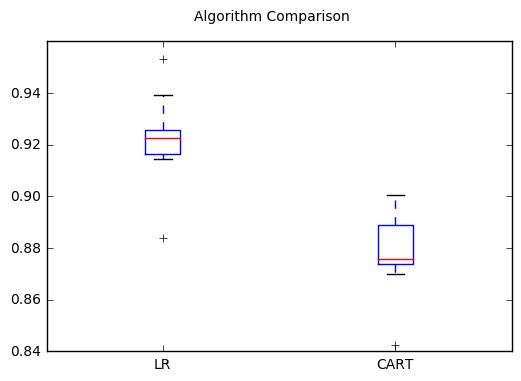

In [142]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Task 2

In [143]:
class BestClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers):
        self.classifiers = classifiers


    def fit(self, X, y=None):
        for cls in self.classifiers.values():
            cls.fit(X, y)
        self._fit = True
        return self

    
    @staticmethod
    def _get_prediction(predictions):
        final_prediction = []
        for pred_classes in predictions:
            freqs = np.bincount(pred_classes)
            most_freq = np.argwhere(freqs == np.amax(freqs))
            size = most_freq.shape[0]
            final_cls = np.random.choice(most_freq.reshape(size,))
            final_prediction.append(final_cls)
        
        return np.array(final_prediction)

    
    def predict(self, X, y=None):
        try:
            getattr(self, "_fit")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        
        predictions = []
        for cls in self.classifiers.values():
            predictions.append(cls.predict(X)[np.newaxis, :])
        return BestClassifier._get_prediction(np.concatenate(predictions).T)

    
    def score(self, X, y=None):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

In [147]:
def get_accuracy_info(cls, cls_name):
    cls.fit(X_train, y_train)
    predictions = cls.predict(X_validation)
    print('Accuracy score of {}: {}'.format(cls_name, accuracy_score(y_validation, predictions)))

In [148]:
classifiers = {'KNN': KNeighborsClassifier(),
               'SVM': SVC(),
               'CART': DecisionTreeClassifier()
              }

In [149]:
my_cls = BestClassifier(classifiers)

### Comparision:

In [150]:
get_accuracy_info(BestClassifier(classifiers), "Best Classifier")

Accuracy score of Best Classifier: 0.8388520971302428


In [151]:
get_accuracy_info(KNeighborsClassifier(), "KNN")
get_accuracy_info(SVC(), "SVM")
get_accuracy_info(DecisionTreeClassifier(), "CART")

Accuracy score of KNN: 0.7549668874172185
Accuracy score of SVM: 0.6401766004415012
Accuracy score of CART: 0.8719646799116998


### Best classifier here is 'LogisticRegression' so I couldn't find such assembly of multiple classifiers to make it better than 'LogisticRegression'

In [152]:
get_accuracy_info(LogisticRegression(), "LR")

Accuracy score of LR: 0.9072847682119205
